![](pics/header.jpg)

# Pinhole Camera Model

Kevin J. Walchko, Phd

21 Dec 2020

---

So there are really good tools in Matlab for camera calibration, but next to none in Python. Here, I am using `opencv_camera` for calibration and producing useful plots for displaying calibration performance.

## References

- tba

## Pinhole Camera Model

![](pics/pinhole_camera_model.png)

Common OpenCV pinhole camera model:

$$
\begin{eqnarray}
  \lambda p(u,v) = K[R|t]P(X,Y,Z) \\
  \lambda \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}
$$

where:

- $P(X^w, Y^w, Z^w)$ are the coordinates of a 3D point in the world coordinate space in meters
- $P(X^c, Y^c, Z^c)$ are the coordinates of a 3D point in the camera coordinate space in meters, the origin is located at the principle point
- p(u, v) are the coordinates of the projection point in pixels
- K is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center in pixel units
- fx, fy are the focal lengths expressed in pixel units
    - In the picture above, the image plane is located at the focal length [meters] along the camera frame's z-axis
- [R|t] are the **extrinsic** parameters (think external parameters)
    - $R$ is the rotation of the camera relative to the world frame
    - $t$ is the translation from the world frame to the camera's location
- $\lambda$ is a scale factor where $\lambda = 1/Z$, which for a single camera is unknown (can't get depth)

> **Normalized Image Plane:** This is done by dividing the 3D point in the camera frame by the Z coordinate. It locates the image plane at the focal length. [1]

$$
\begin{eqnarray}
  \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = K \hat p = \frac{1}{Z^c} 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} X^c \\ Y^c \\ Z^c \end{bmatrix} = \frac{1}{Z^c} 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X^w \\ Y^w \\ Z^w \\ 1 \end{bmatrix}
\end{eqnarray} \\
\hat p = \begin{bmatrix} x^c & y^c & 1 \end{bmatrix}^T = \begin{bmatrix} X^c & Y^c & Z^c \end{bmatrix}^T \frac{1}{Z^c} \\
f_x = \frac{f}{\delta_{w}} \\
f_y = \frac{f}{\delta_{h}}
$$

where $\hat p$ is a normalized point in the camera frame, $\delta$ is the pixel size, $f_x$  and $f_y$ are the adjusted focal length (or principle distance) in pixels. The superscript $c$ is for the camera frame and the superscript $w$ is for the world frame.

## Projection Matrix

The projection matrix (P) gives the relationship between world coordinates and image plane coordinates. 

$$
P = K [R|t]
$$

## Focal Length

There is only one focal length ($f$) for a camera and it is the distance between the focal point and the image plane. Unfortunately, you can't always find a pixel size to calculate the focal length in pixels. Another way to do this is:

$$
f_x = \frac{f}{\delta_{w}} = f \cdot \frac{image_{width}}{sensor_{width}}\\
f_y = \frac{f}{\delta_{h}} = f \cdot \frac{image_{height}}{sensor_{height}}
$$ 

### Example

OpenCV will output the camera's focal length in pixels ($f_{px}$), this example will give you an idea for how to determine if the calibrated answer is correct or not. Also, due to mechanical misalignments during the camera building process, the answer below is not what OpenCV will produce. The answer below is an ideal answer based off of a datasheet, but you should get something relatively close.

**Raspberry Pi Camera v2.1**

$$
f_{px} = f_{mm}*\frac{resolution_{px}}{sensorSize_{mm}}
$$

| Parameter | Value |
|---|---|
| Sensor | Sony IMX219 |
| Active Array Size | 3280 x 2464 pixels |
| Image Area | 3.68 mm x 2.76 mm |
| Camera Focal Length | 3.04 mm |

In [12]:
fx = 3.04*3280/(3.68)
fy = 3.04*2464/(2.76)
print(f'Focal length (x,y) in pixels: {fx:.2f} {fy:.2f}')

Focal length (x,y) in pixels: 2709.57 2713.97


## Field of View

![](pics/fov.png)

Luckily the math for the pinhole camera model is just simple trig. There is a FOV for both the width and height of the camera sensor. It follows the same format as below:

![](pics/fov-eqn.png)

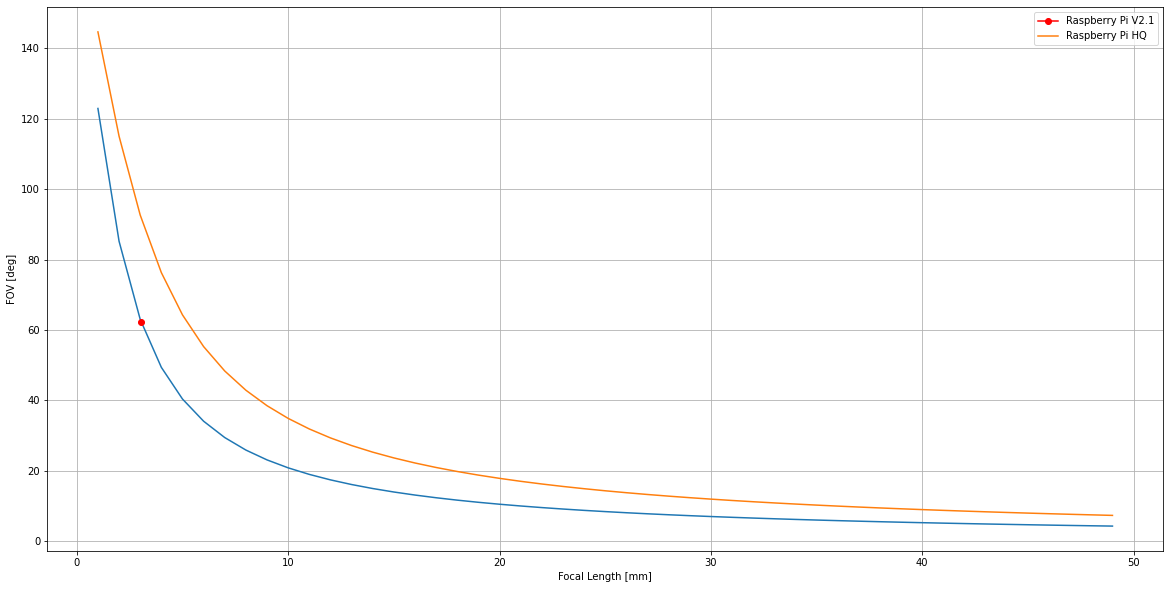

In [39]:
from numpy import arctan2, pi, arange,tan
from matplotlib import pyplot as plt

def fov(f, w):
    return 2*arctan2(w,2*f)*180/pi

# print("w=",2*3.04*tan(62.2/2*pi/180))

# w = 3.68 #0.004 # mm
f = arange(1,50) # mm
plt.plot(f, fov(f,w))
plt.plot(3.04, fov(3.04, 3.68), "o-r", label="Raspberry Pi V2.1")
plt.plot(f, fov(f, 6.287), label="Raspberry Pi HQ")
plt.ylabel("FOV [deg]")
plt.xlabel("Focal Length [mm]")
plt.legend()
plt.grid(True);

## Camera Motion

$$
\begin{bmatrix} u \\ v \end{bmatrix} = \frac{f}{Z} \begin{bmatrix} X \\ Y \end{bmatrix} \\
\dot p = T + \omega \times p \\
\dot u = \frac{T_z u - T_x f}{Z} - \omega_y f + \omega_z v + \frac{\omega_x u v}{f} - \frac{\omega_y u^2}{f} \\
\dot v = \frac{T_z v - T_y f}{Z} + \omega_x f - \omega_z u + \frac{\omega_y u v}{f} - \frac{\omega_y v^2}{f}
$$

where $T$ is the translation of the camera, $\omega$ is the rotation of the camera, $(X,Y,Z)$ is the 3D location, $f$ is the focal length, and $(u,v)$ is the pixel coordinates 

## Distortion Model

The distortion model used in [OpenCV](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html) is:

$$
\begin{bmatrix} u_r \\ v_r \end{bmatrix} = \begin{bmatrix}u \\ v \end{bmatrix}(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
\begin{bmatrix} u_t \\ v_t \end{bmatrix} = 
\begin{bmatrix}
  u (1+2p_1xy+p_2(r^2+2x^2)) \\
  v (1+p_1(r^2+2y^2) + 2p_2xy)
\end{bmatrix} \\
r^2 = u^2 + v^2
$$

where subscript $r$ is for radial distortion and subscript $t$ is for tangental distortion.